<a href="https://colab.research.google.com/github/vieirafrancisco/machine-learning-ufal/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sobre o Dataset
Será utilizado o dataset utilizado na primeira semana.  
Boa parte das análises e pré-processamento foram feitas no [link](https://github.com/vieirafrancisco/machine-learning-ufal/blob/master/limpeza_dos_dados_e_analise_preliminar.ipynb)  

O objetivo é verificar se é possível prever a quantidade de vendas globais de um determinado jogo, dependendo das informações da desenvolvedora e do feedback dos jogadores ao longo dos anos.

In [1]:
import os
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [2]:
os.chdir('drive/My Drive/UFAL/machine-learning-ufal/video-game-sales/')

# Imports

In [67]:
import random
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [6]:
!ls data

animal-pre			 fraud_dataset_read_to_use.csv
download			 fraud_dataset_ready_to_use.csv
download.1			 pre_processed.csv
fraud_dataset.csv		 raw-img
fraud_dataset_pre_processed.csv  video-game-sales-22-dec-2016.csv


In [105]:
df = pd.read_csv('data/pre_processed.csv')

In [106]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,E
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,E
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,E
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,E
4,Wii Play,Wii,2006,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,E


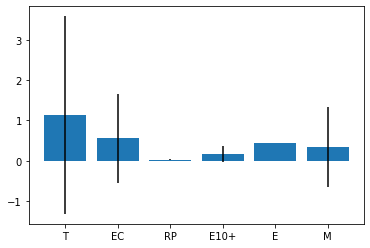

In [156]:
# baseado no código do prof. Rodolfo
indice = list(set(df['Rating']))
stats = df.groupby(['Rating'],as_index=False)['Global_Sales'].agg(['mean','std'])
plt.bar(indice,stats['mean'],yerr=stats['std'])
plt.show()

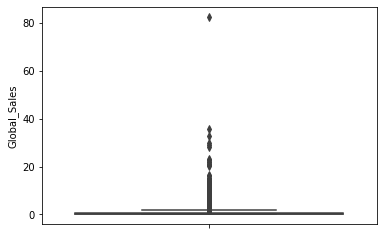

In [82]:
sns.boxplot(data=df, y='Global_Sales')

In [158]:
# remover os outliers portque tem muitos dados muito acima do resto dos outros
def remove_outliers(df, attr):
  data = df[attr]
  iqr = data.quantile(.75) - data.quantile(.25)
  sup = min(data.quantile(.75) + (iqr * 1.5), data.max())
  inf = max(data.quantile(.25) - (iqr * 1.5), data.min())
  indexes = [idx for idx, value in enumerate(data) if inf <= value <= sup]
  return df.iloc[indexes] 

df_wo = remove_outliers(df, 'Global_Sales')

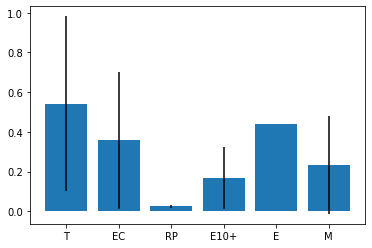

In [160]:
# baseado no código do prof. Rodolfo
indice = list(set(df_wo['Rating']))
stats = df_wo.groupby(['Rating'],as_index=False)['Global_Sales'].agg(['mean','std'])
plt.bar(indice,stats['mean'],yerr=stats['std'])
plt.show()

Boa parte das vendas do jogos (neste dataset) são referentes a jogos recomendados para criaças e adolecentes

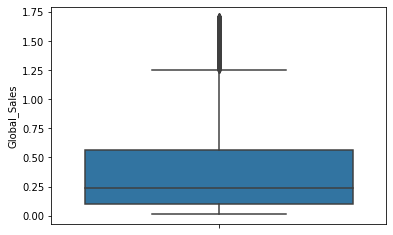

In [84]:
sns.boxplot(y=df_wo['Global_Sales'])

A quantidade de vendas dos jogos globalmente variam entre 0 (provavelmente na escada dos mil) a 1.75 milhões de cópias.

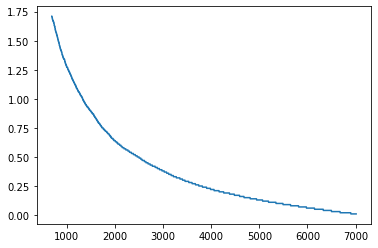

In [85]:
 # o gráfico ficou dessa forma porque os dados já estavam ordenados naturalmente no dataset
plt.plot(df_wo['Global_Sales'])

In [161]:
# normalizar Critic_Score com User_Score dividindo por 10
df_wo['Critic_Score'] = df_wo['Critic_Score'] / 10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [162]:
# drop columns
df_wo.drop(['Name', 'NA_Sales', 'JP_Sales', 'EU_Sales', 'Other_Sales', 'Year_of_Release'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [96]:
df_wo.head()

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
688,X360,2012,Action,Bethesda Softworks,1.71,8.8,56.0,7.9,815.0,E
689,Wii,2009,Misc,MTV Games,1.71,8.9,25.0,8.9,43.0,E
690,PS2,2004,Simulation,Sony Computer Entertainment Europe,1.71,8.4,57.0,9.1,81.0,E
691,XB,2003,Racing,Electronic Arts,1.71,8.3,25.0,8.7,35.0,E
692,DS,2007,Misc,Mindscape,1.70,2.0,13.0,1.9,41.0,E


In [163]:
# dricretizar atributos categóricos
def discretize(df, columns):
  tmp = df.copy()
  for column in columns:
    c = {key: idx for idx, key in enumerate(set(tmp[column]))}
    tmp[column] = [c[value] for value in tmp[column]]
  return tmp

df_wo = discretize(df_wo, ['Platform', 'Publisher', 'Genre', 'Rating'])

In [128]:
df_wo.head()

,Platform,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
688,15,9,224,1.71,8.8,56.0,7.9,815.0,4
689,14,0,112,1.71,8.9,25.0,8.9,43.0,4
690,2,1,201,1.71,8.4,57.0,9.1,81.0,4
691,1,8,27,1.71,8.3,25.0,8.7,35.0,4
692,5,0,104,1.70,2.0,13.0,1.9,41.0,4


In [164]:
# re-escala min-max
for column in df_wo.columns:
  min_v = df_wo[column].min()
  max_v = df_wo[column].max()
  df_wo[column] = [(value-min_v)/(max_v-min_v) for value in df_wo[column]]

In [144]:
# save
df_wo.to_csv('data/video-game-sales-pre-processed.csv')

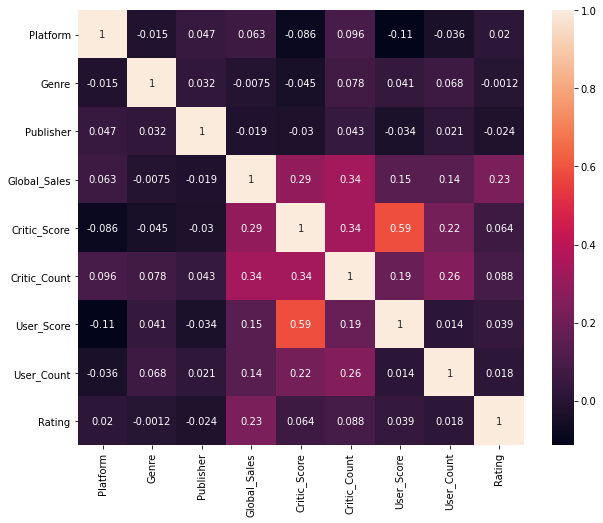

In [148]:
# correlação
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(df_wo.corr(), annot=True, ax=ax)

As correlações com o Global_Sales são quase todas próximas de zero.  
Somente o Critic_Score e o Critic_Count tem uma relação levemente positiva.  
Isso pode ser uma caracteristica de que os atributos não descrevem o label (Global_Sales)

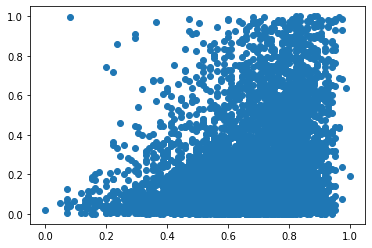

In [165]:
plt.scatter(df_wo['Critic_Score'], df_wo['Global_Sales'])

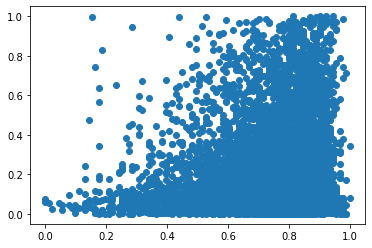

In [166]:
plt.scatter(df_wo['User_Score'], df_wo['Global_Sales'])

In [172]:
y = df_wo['Global_Sales']
X = df_wo.drop(['Global_Sales'], axis=1)

Os atributos de score tem uma correlação levemente pósitiva com o atributo de classe.  
Faz todo o sentido, porque quanto maior as notas possívelmente maior vai ser o número de vendas global.

# Regressão

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [180]:
# definindo modelo de regressão linear
linear = LinearRegression()
linear.fit(X_train,y_train)
pred_linear = linear.predict(X_test)

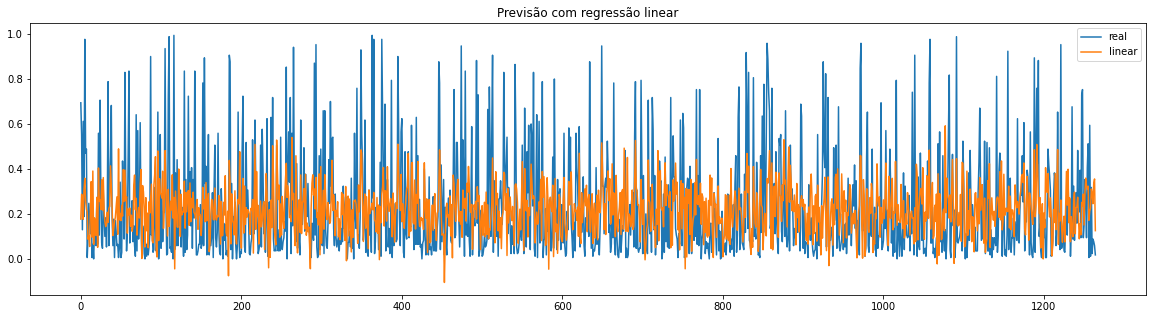

In [188]:
#plotando resultados da MLP
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(y_test.reset_index(drop=True),label='real')
plt.plot(pred_linear,label='linear')
plt.legend()
plt.title('Previsão com regressão linear')
plt.show()

In [182]:
#definindo modelo de árvore de decisão
arvore = DecisionTreeRegressor()
arvore.fit(X_train,y_train)
pred_arvore = arvore.predict(X_test)

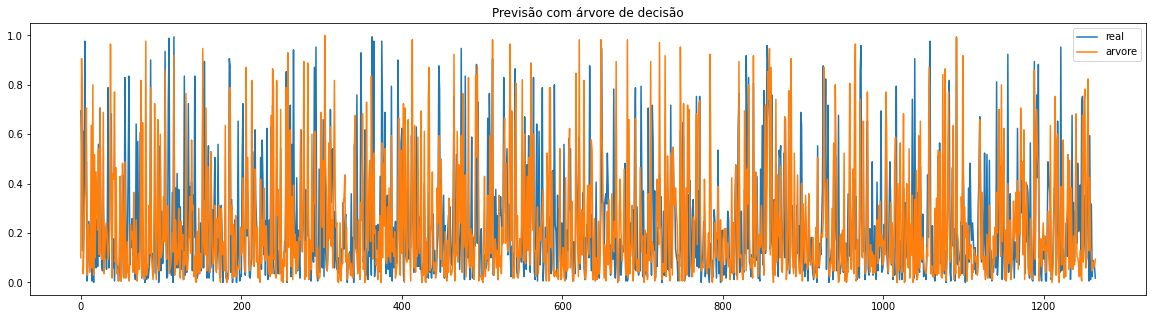

In [189]:
#plotando resultados da árvore de decisão
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(y_test.reset_index(drop=True),label='real')
plt.plot(pred_arvore,label='arvore')
plt.legend()
plt.title('Previsão com árvore de decisão')
plt.show()

In [190]:
#definindo modelo de random forest
floresta = RandomForestRegressor(n_estimators=100)
floresta.fit(X_train,y_train)
pred_floresta = floresta.predict(X_test)

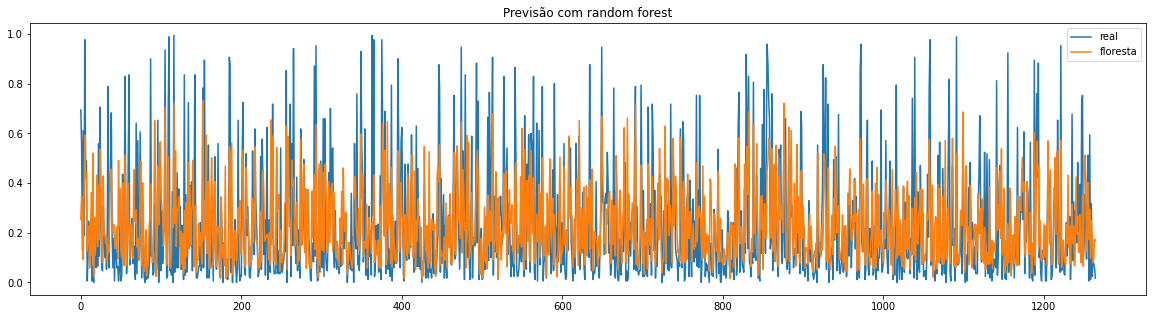

In [191]:
#plotando resultados da random forest
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(y_test.reset_index(drop=True),label='real')
plt.plot(pred_floresta,label='floresta')
plt.legend()
plt.title('Previsão com random forest')
plt.show()

In [186]:
#define modelo MLP
mlp = MLPRegressor(hidden_layer_sizes=(200,50),activation='logistic',max_iter=1000)
mlp.fit(X_train,y_train)
pred_mlp = mlp.predict(X_test)

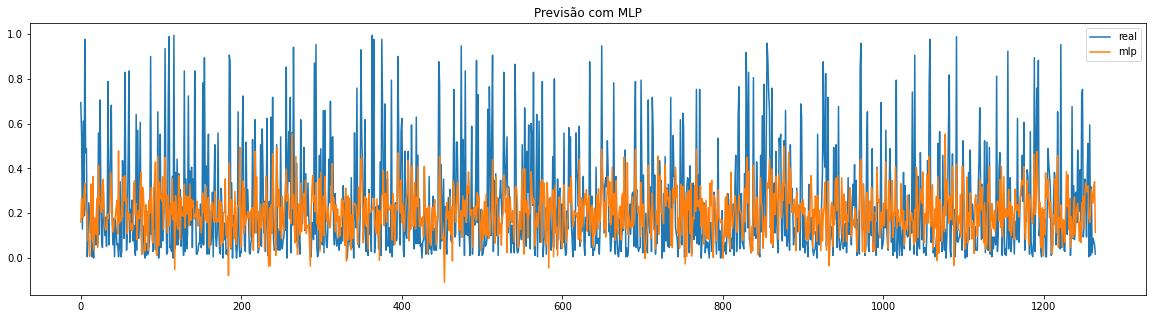

In [192]:
#plotando resultados da MLP
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(y_test.reset_index(drop=True),label='real')
plt.plot(pred_mlp,label='mlp')
plt.legend()
plt.title('Previsão com MLP')
plt.show()

# Avaliação

In [199]:
from sklearn.metrics import mean_squared_error

In [200]:
mean_squared_error(y_test,pred_linear)

0.04489536557634584

In [201]:
mean_squared_error(y_test,pred_arvore)

0.060527736367739386

In [202]:
mean_squared_error(y_test,pred_floresta)

0.03148270222672665

In [203]:
mean_squared_error(y_test,pred_mlp)

0.04570486602110661

# Conclusão
Visualmente falando a Árvore de Decisão pareceu se dar melhor na previsão, porém no MSE ela foi a pior e a Random Forest a melhor. Creio que esses dados para prever esse atributo Global_Sales não é o sufiente. Possívelmente é necessario obter mais dados e também mais atributos para verificar a minha hipótese, de que é possivel prever o número de vendas globais de um determinado jogo, dependendo tanto da popularidade da empresa de desenvolvimentos (e das franquias), como também do feedback dos jogadores e profissionais na área de jogos.